# This notebook contains code for plotting the mutation rate as a function of distance from the CDR

In [4]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

### Starting with SVs 

In [5]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [5]:
def load_matching_beds(chr_str, bed_folder, pairs_df):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4, 6, 7, 8, 14]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "type",
        "diff",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_dist",
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):
        if not fname.endswith(".CDR_dist.bed"):
            continue

        base = fname.replace(".CDR_dist.bed", "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        if bed_df.shape[1] <= max(col_indices):
            print("Unexpected column count:", bed_path, bed_df.shape[1])
            continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)


In [8]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_to_CDR/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

all_chrom_dfs = []

for chrom in chroms:
    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,type,diff,CDR_start,CDR_end,CDR_status,CDR_dist,sample1,sample2,chr,both_pairs_CDR
0,HG01123#2#CM089095.1,122553663,122553664,D,-1.0,123264267,123277330,CDR,710604,HG002.1,HG01123.2,chr1,False
1,HG01123#2#CM089095.1,122574683,122577741,I,-1.0,123264267,123277330,CDR,686527,HG002.1,HG01123.2,chr1,False
2,HG01123#2#CM089095.1,122607401,122630863,I,-1.0,123264267,123277330,CDR,633405,HG002.1,HG01123.2,chr1,False
3,HG01123#2#CM089095.1,122631246,122636338,I,-1.0,123264267,123277330,CDR,627930,HG002.1,HG01123.2,chr1,False
4,HG01123#2#CM089095.1,122637469,122643919,I,-1.0,123264267,123277330,CDR,620349,HG002.1,HG01123.2,chr1,False


In [10]:
# Save dataframe out to file to save time 
# Save dataframe to phoenix to avoid re-creating it again
final_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/variant_dist_to_CDR/all_chroms_SV_df_0.2_dist.parquet")

In [22]:
def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

In [23]:
final_df["shape"] = final_df["diff"].apply(classify_shape)

In [ ]:
## Get count of unique pairs per chromosome and unique pairs where both pairs have CDR annotations 

# Create a column that identifies the pair (order-insensitive)
final_df["pair"] = final_df.apply(lambda row: frozenset([row["sample1"], row["sample2"]]), axis=1)

# Total unique pairs per chromosome
total_pairs_per_chr = final_df.groupby("chr")["pair"].nunique().rename("total_pairs")

# Unique pairs per chromosome where both_pairs_CDR == True
cdr_pairs_per_chr = (
    final_df[final_df["both_pairs_CDR"]]
    .groupby("chr")["pair"]
    .nunique()
    .rename("cdr_pairs")
)

# Combine into one summary DataFrame
summary_pairs_df = pd.concat([total_pairs_per_chr, cdr_pairs_per_chr], axis=1).fillna(0).astype(int)

print(summary_pairs_df)

       total_pairs  cdr_pairs
chr                          
chr1           314        197
chr10          133         76
chr11          454        342
chr12          241        162
chr13          134         76
chr14          229         92
chr15           99         72
chr16          334        238
chr17           22         16
chr18           13          8
chr19          235        157
chr2           469        334
chr20          199        126
chr21          139         85
chr22          303        143
chr3            46         32
chr4             5          4
chr5           147        114
chr6            33         29
chr7           142         93
chr8           285        202
chr9           290        202
chrX           330        242
chrY            28         13


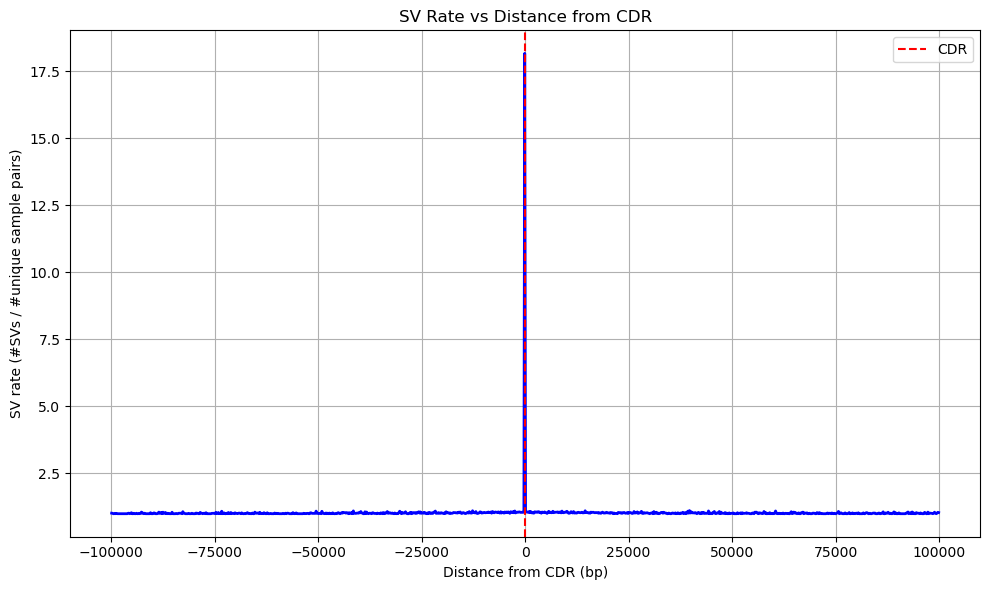

In [27]:
### Plot distance from CDR summarized across all chromosomes 

# Subset rows where both_pairs_CDR == True
df_cdr = final_df[final_df["both_pairs_CDR"]].copy()

df_cdr = df_cdr[df_cdr["shape"] == "triangle"].copy()


# Define bin edges: -2,000,000 to +2,000,000, 1000 bins
bin_edges = np.linspace(-100_000, 100_000, 1001)  # 1000 bins → 1001 edges

# Assign each row to a bin
df_cdr["bin"] = pd.cut(df_cdr["CDR_dist"], bins=bin_edges, labels=False, include_lowest=True)

# Count SVs per bin
sv_counts = df_cdr.groupby("bin").size().rename("num_SVs")

# Count unique sample pairs per bin
df_cdr["pair"] = df_cdr.apply(lambda row: frozenset([row["sample1"], row["sample2"]]), axis=1)

unique_pairs_per_bin = df_cdr.groupby("bin")["pair"].nunique().rename("num_pairs")

# Compute SV rate per bin
sv_rate_per_bin = (sv_counts / unique_pairs_per_bin).fillna(0).rename("SV_rate")

# summarize into dataframe 
bins_df = pd.DataFrame({
    "bin_index": sv_rate_per_bin.index,
    "num_SVs": sv_counts,
    "num_pairs": unique_pairs_per_bin,
    "SV_rate": sv_rate_per_bin
}).reset_index(drop=True)

# compute bin center in bp for plotting:
bins_df["bin_center"] = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(10,6))

plt.plot(
    bins_df["bin_center"],    # x-axis: distance from CDR
    bins_df["SV_rate"],       # y-axis: SV rate
    color='blue',
    lw=2
)

plt.axvline(0, color='red', linestyle='--', label="CDR")
plt.xlabel("Distance from CDR (bp)")
plt.ylabel("SV rate (#SVs / #unique sample pairs)")
plt.title("SV Rate vs Distance from CDR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



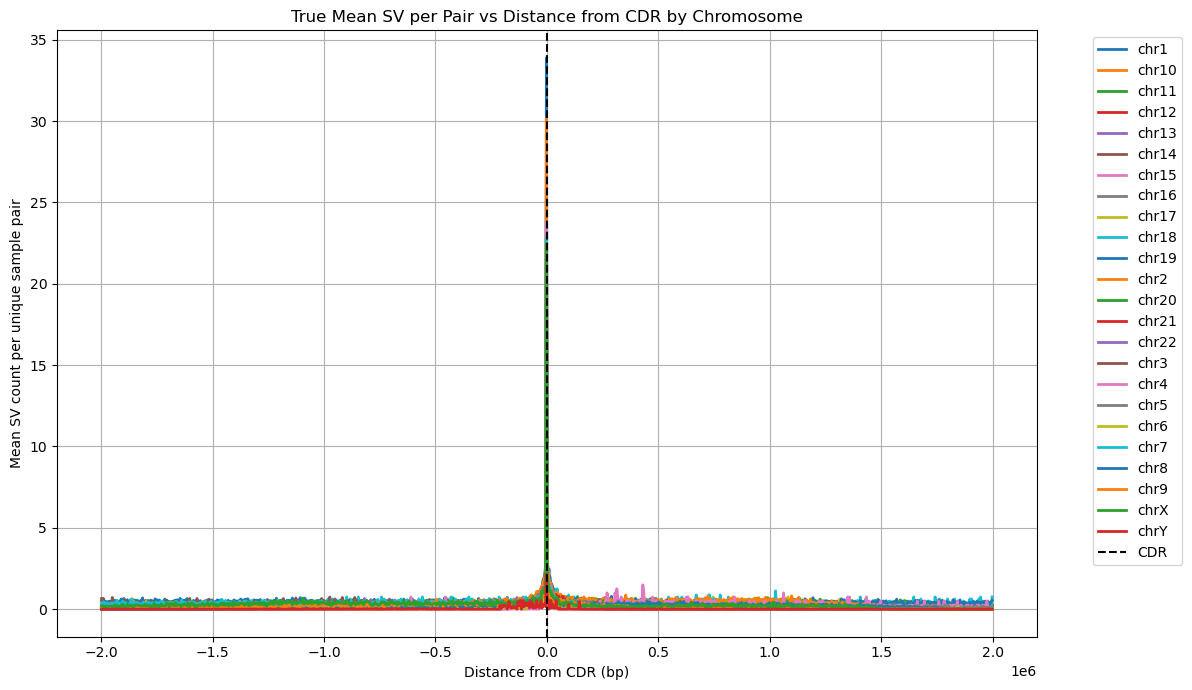

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# -------------------------------
# Step 1: Subset rows where both_pairs_CDR == True
# -------------------------------
df_cdr = final_df[final_df["both_pairs_CDR"]].copy()

# -------------------------------
# Step 2: Define bins
# -------------------------------
bin_edges = np.linspace(-2_000_000, 2_000_000, 1001)  # 1000 bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# -------------------------------
# Step 3: Plot true mean SV per pair per bin for each chromosome
# -------------------------------
plt.figure(figsize=(12,7))

for chrom in sorted(df_cdr["chr"].unique()):
    df_chr = df_cdr[df_cdr["chr"] == chrom].copy()
    
    # Assign bins
    df_chr["bin"] = pd.cut(df_chr["CDR_dist"], bins=bin_edges, labels=False, include_lowest=True)
    
    # Order-insensitive sample pairs
    df_chr["pair"] = df_chr.apply(lambda row: frozenset([row["sample1"], row["sample2"]]), axis=1)
    
    # Count SVs per pair per bin
    pair_bin_counts = df_chr.groupby(["bin", "pair"]).size().rename("SV_count").reset_index()
    
    # All unique pairs in this chromosome
    all_pairs = df_chr["pair"].unique()
    
    # All bins
    all_bins = np.arange(1000)
    
    # Cartesian product: all bins x all pairs
    all_bin_pair = pd.DataFrame(list(itertools.product(all_bins, all_pairs)), columns=["bin", "pair"])
    
    # Merge actual counts; missing → 0
    full_pair_bin_counts = all_bin_pair.merge(pair_bin_counts, on=["bin", "pair"], how="left").fillna(0)
    
    # Compute mean SV count per pair per bin
    mean_sv_per_bin = full_pair_bin_counts.groupby("bin")["SV_count"].mean()
    
    # Optional smoothing
    #mean_sv_per_bin_smooth = mean_sv_per_bin.rolling(window=10, center=True, min_periods=1).mean()
    
    # Plot
    plt.plot(bin_centers, mean_sv_per_bin, label=chrom, lw=2)

# CDR reference line
plt.axvline(0, color='black', linestyle='--', label="CDR")

# Labels and styling
plt.xlabel("Distance from CDR (bp)")
plt.ylabel("Mean SV count per unique sample pair")
plt.title("True Mean SV per Pair vs Distance from CDR by Chromosome")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # place legend outside
plt.grid(True)
plt.tight_layout()
plt.show()



### Using SV windows to calculate rates 

In [8]:
def load_matching_beds(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [ ]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR
0,HG01123#2#CM089095.1,122533947,122543947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,720321,HG002.1,HG01123.2,chr1,False
1,HG01123#2#CM089095.1,122543947,122553947,0,0.0,0,0.0,1,0.0001,HG01123#2#CM089095.1,123264267,123277330,CDR,710321,HG002.1,HG01123.2,chr1,False
2,HG01123#2#CM089095.1,122553947,122563947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,700321,HG002.1,HG01123.2,chr1,False
3,HG01123#2#CM089095.1,122563947,122573947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,690321,HG002.1,HG01123.2,chr1,False
4,HG01123#2#CM089095.1,122573947,122583947,0,0.0,0,0.0,3058,0.3058,HG01123#2#CM089095.1,123264267,123277330,CDR,680321,HG002.1,HG01123.2,chr1,False


In [17]:
## Write out dataframe to file
final_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/all_chroms_SV_df.10kb.CDRdist.0.2.parquet")

In [4]:
final_df = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/all_chroms_SV_df.10kb.CDRdist.0.2.parquet")

In [5]:
# add rate for all variants
final_df["all_counts"] = (
    final_df["par_counts"]
    + final_df["trap_counts"]
    + final_df["tri_counts"]
)

final_df["all_rate"] = final_df["all_counts"] / 10000
final_df.head()

,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR,all_counts,all_rate
0,HG01123#2#CM089095.1,122533947,122543947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,720321,HG002.1,HG01123.2,chr1,False,0,0.0000
1,HG01123#2#CM089095.1,122543947,122553947,0,0.0,0,0.0,1,0.0001,HG01123#2#CM089095.1,123264267,123277330,CDR,710321,HG002.1,HG01123.2,chr1,False,1,0.0001
2,HG01123#2#CM089095.1,122553947,122563947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,700321,HG002.1,HG01123.2,chr1,False,0,0.0000
3,HG01123#2#CM089095.1,122563947,122573947,0,0.0,0,0.0,0,0.0000,HG01123#2#CM089095.1,123264267,123277330,CDR,690321,HG002.1,HG01123.2,chr1,False,0,0.0000
4,HG01123#2#CM089095.1,122573947,122583947,0,0.0,0,0.0,3058,0.3058,HG01123#2#CM089095.1,123264267,123277330,CDR,680321,HG002.1,HG01123.2,chr1,False,3058,0.3058


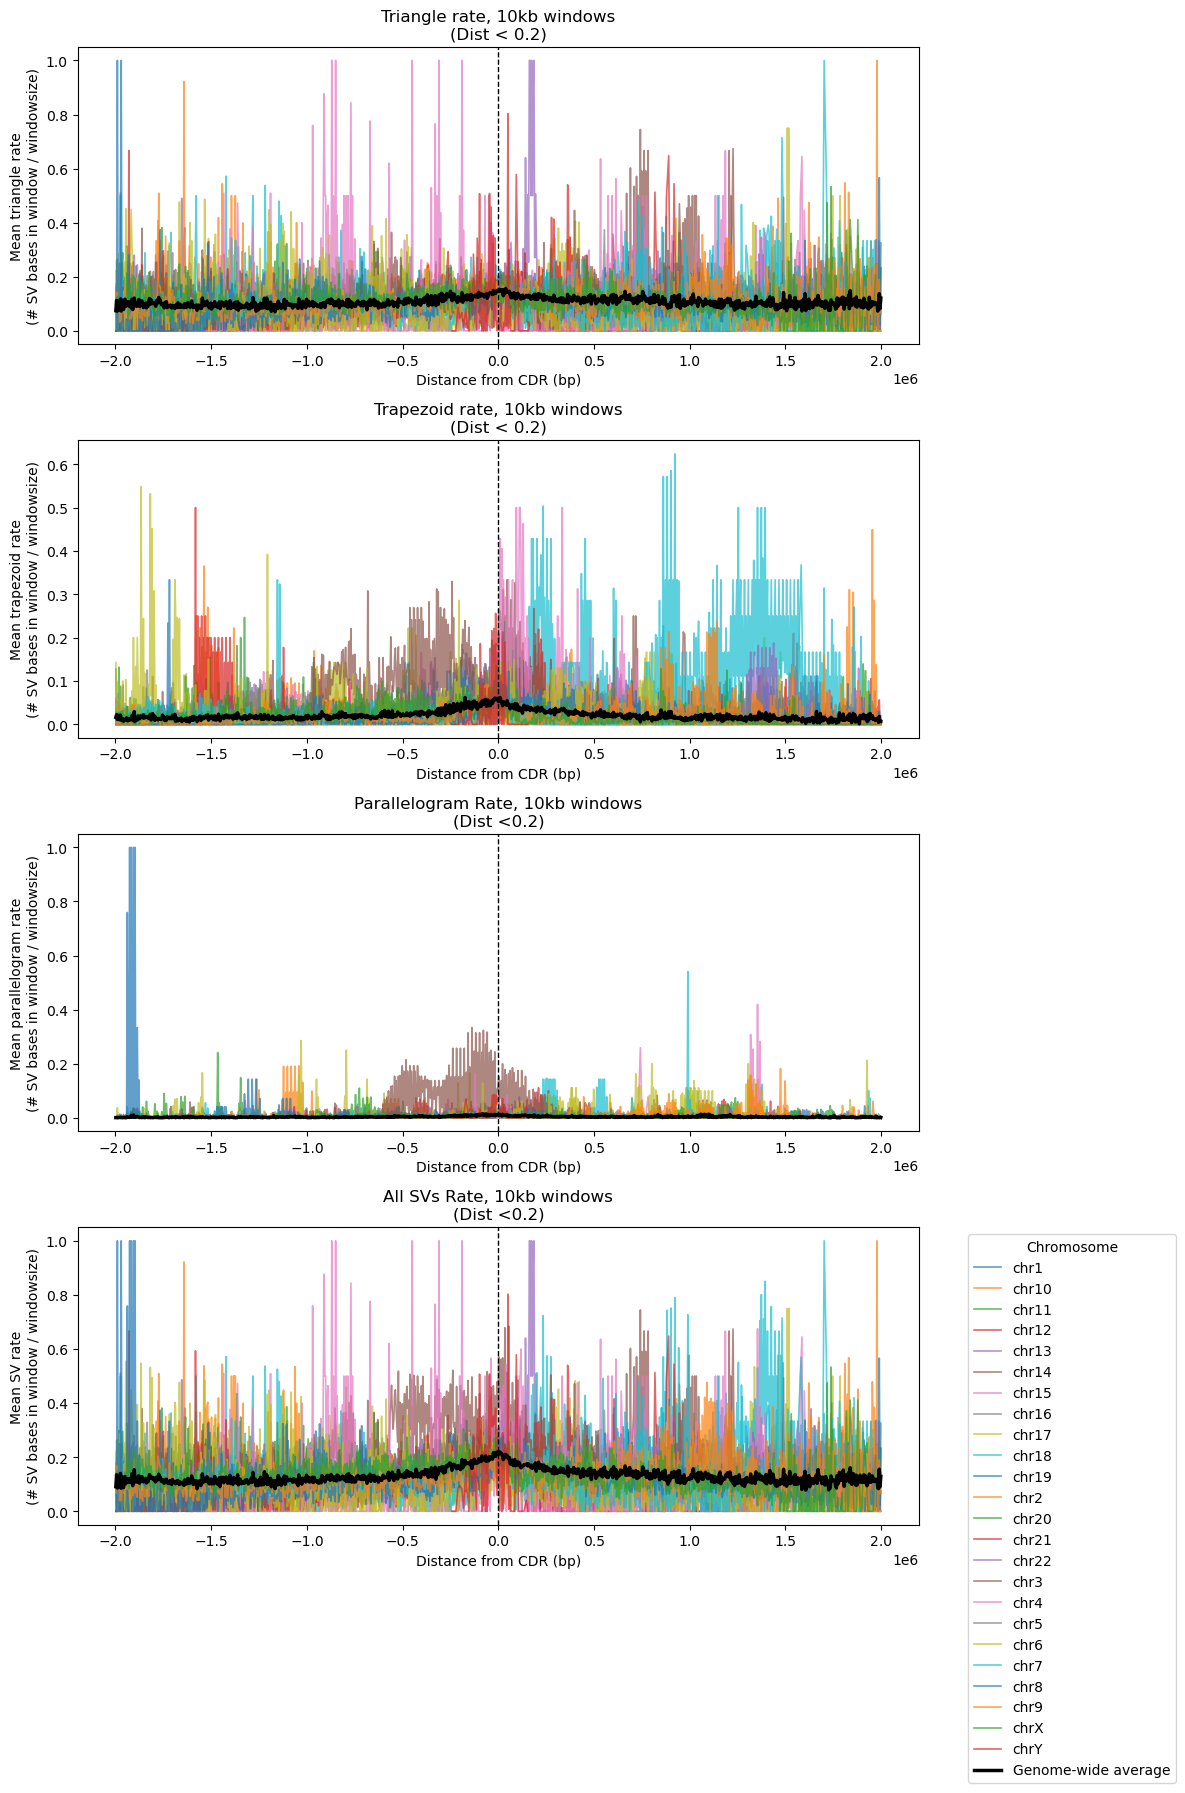

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = final_df[final_df["CDR_start"] != -1].copy()

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and manual titles
rate_columns = ["tri_rate", "trap_rate", "par_rate", "all_rate"]
plot_titles = ["Triangle rate, 10kb windows\n(Dist < 0.2)", "Trapezoid rate, 10kb windows\n(Dist < 0.2)", "Parallelogram Rate, 10kb windows\n(Dist <0.2)", "All SVs Rate, 10kb windows\n(Dist <0.2)"]
y_labels = ["Mean triangle rate\n(# SV bases in window / windowsize)", "Mean trapezoid rate\n(# SV bases in window / windowsize)", "Mean parallelogram rate\n(# SV bases in window / windowsize)", "Mean SV rate\n(# SV bases in window / windowsize)"]

# 4. Create subplots
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 18))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # Aggregate per chromosome
    agg = (
        df
        .groupby(["chr", "distance_bin"], as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
    )

    # Aggregate genome-wide
    genome_avg = (
        df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=(rate_col, "mean"))
        .sort_values("distance_bin")
    )

    # Per-chromosome lines
    for chrom, chrom_df in agg.groupby("chr"):
        chrom_df = chrom_df.sort_values("distance_bin")
        ax.plot(
            chrom_df["distance_bin"],
            chrom_df["mean_rate"],
            label=str(chrom),
            linewidth=1.2,
            alpha=0.7
        )

    # Genome-wide average (black, thick, on top)
    ax.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color="black",
        linewidth=2.5,
        label="Genome-wide average",
        zorder=10
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Distance from CDR (bp)")
    ax.set_title(title)  # Manually set title here

# Legend on the last subplot
axes[-1].legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


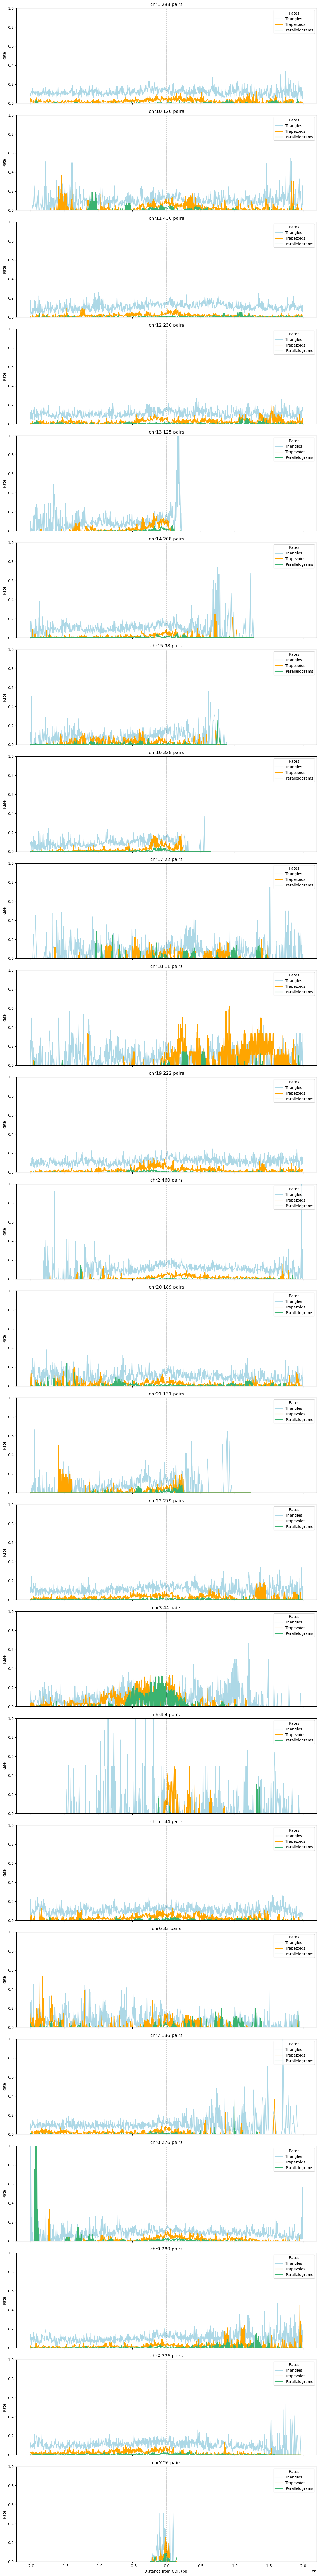

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for valid CDR positions
df = final_df[final_df["CDR_start"] != -1].copy()

# Define bins and bin centers
window_range = 2_000_000
n_bins = 1000
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# Assign each row to a distance bin
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# List of chromosomes
chromosomes = sorted(df["chr"].unique())

# Assign a color to each rate
rate_colors = {
    "tri_rate": "lightblue",
    "trap_rate": "orange",
    "par_rate": "mediumseagreen",
    "all_rate": "grey"
}
legend_labels = {
    "tri_rate": "Triangles",
    "trap_rate": "Trapezoids",
    "par_rate": "Parallelograms",
    "all_rate": "All Features"
}
# Count unique sample pairs per chromosome
pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# Create subplots: one panel per chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(12, 4 * len(chromosomes)), sharex=True)

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # Plot TRI, TRAP, PAR rates
    for rate_col in ["tri_rate", "trap_rate", "par_rate"]:
        agg = (
            chrom_df
            .groupby("distance_bin", as_index=False)
            .agg(mean_rate=(rate_col, "mean"))
            .sort_values("distance_bin")
        )
        ax.plot(
            agg["distance_bin"],
            agg["mean_rate"],
            color=rate_colors[rate_col],
            linewidth=1.5,
            label=legend_labels[rate_col]  # renamed
        )

    # Plot ALL rate in black, thicker line
    agg_all = (
        chrom_df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("all_rate", "mean"))
        .sort_values("distance_bin")
    )
    # ax.plot(
    #     agg_all["distance_bin"],
    #     agg_all["mean_rate"],
    #     color=rate_colors["all_rate"],
    #     linewidth=1.5,
    #     label="All Rate",
    #     zorder=10
    # )

    # Vertical line at CDR
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Axis limits, labels, title
    ax.set_ylim(0, 1)
    ax.set_ylabel("Rate")
    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"{chrom} ({n_pairs} pairs)")
    ax.legend(title="Rates", loc="upper right")

# x-axis label for the bottom panel
axes[-1].set_xlabel("Distance from CDR (bp)")

# Legend on the top panel
#axes[0].legend(title="Rates", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Short indels mutation rate 

In [10]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/short_indels_pairwise/1kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.1kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
final_short_indel_df = pd.concat(all_chrom_dfs, ignore_index=True)

final_short_indel_df.head()

Processing chr1...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr2...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr10...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


Processing chr15...
Processing chr16...


/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(
/data/tmp/ipykernel_1410707/3998127185.py:44: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(


EmptyDataError: No columns to parse from file